In [1]:
# BLOCK 1 – Configuration Block (edit only DATA_ROOT)
from pathlib import Path
import os, time, pickle, hashlib
import numpy as np
from math import ceil
from tqdm import tqdm
from collections import defaultdict

# ---------- EDIT IF NEEDED ----------
DATA_ROOT = "data"  # ✅ Changed to mango disease folders
# ------------------------------------

# Cache & artifact locations
CACHE_DIR = Path('./embeddings_cache')
CACHE_DIR.mkdir(exist_ok=True)
EMB_FILE = CACHE_DIR / 'X_emb.npy'
LBL_FILE = CACHE_DIR / 'y_lbl.npy'
PATHS_FILE = CACHE_DIR / 'paths.npy'
CLF_FILE = CACHE_DIR / 'svc_model.pkl'
CENTROIDS_FILE = CACHE_DIR / 'centroids.npy'
CLASSES_FILE = CACHE_DIR / 'classes.npy'

# Image extensions
EXTS = {'.jpg', '.jpeg', '.png'}
IMAGE_SIZE = (224, 224)  # ✅ Changed from 160x160
print("DATA_ROOT:", DATA_ROOT)

DATA_ROOT: data


In [2]:
"""
=========================================================
Block 2 – FIXED: EfficientNetV2-B0 (Better than Lite2)
Uses native Keras Applications (more stable + higher accuracy)
=========================================================
"""

import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TensorFlow:", tf.__version__)

# ---------------- CONFIG ----------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30  # Increased for better convergence
DATA_DIR = "data"
MODEL_CACHE = "models/efficientnetv2_b0_head"
BEST_MODEL = "models/efficientnetv2_b0_best.h5"
# ---------------------------------------

os.makedirs("models", exist_ok=True)

# --------- Enhanced Data Augmentation ---------
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.15,
    # Stronger augmentation for better generalization
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Valid for disease images
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.15
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print("Classes:", train_gen.class_indices)
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")

# =========================================================
# 🔥 LOAD FROM CACHE IF EXISTS
# =========================================================
if os.path.exists(BEST_MODEL):
    print("✅ Loading cached best model:", BEST_MODEL)
    train_model = load_model(BEST_MODEL)
    
else:
    print("🚀 Training EfficientNetV2-B0 from scratch")
    
    # --------- Build Model ---------
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMAGE_SIZE, 3),
        pooling=None
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    inputs = Input(shape=(*IMAGE_SIZE, 3), name="image")
    x = base_model(inputs, training=False)
    
    # Enhanced head architecture
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    
    train_model = Model(inputs, outputs)
    
    # --------- Compile ---------
    train_model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    print("\n=== Phase 1: Train head only ===")
    train_model.summary()
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
        BEST_MODEL,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Phase 1: Train head
    history1 = train_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )
    
    # --------- Fine-tune ---------
    print("\n=== Phase 2: Fine-tune top layers ===")
    
    # Unfreeze last 30 layers
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    train_model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history2 = train_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )
    
    # Load best weights
    train_model = load_model(BEST_MODEL)
    print("💾 Best model saved to:", BEST_MODEL)

# =========================================================
# 🔹 EMBEDDING MODEL (for SVM/Centroid)
# =========================================================
# Extract features from the layer BEFORE final classification
embedding_model = Model(
    inputs=train_model.input,
    outputs=train_model.layers[-3].output,  # Before last Dense
    name="embedding_model"
)

EMBEDDING_DIM = embedding_model.output_shape[-1]
print("\n✅ Model ready!")
print(f"🔍 Embedding dimension: {EMBEDDING_DIM}")
print(f"📊 Final validation accuracy: {train_model.evaluate(val_gen)[1]:.4f}")

TensorFlow: 2.20.0
Found 3400 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Classes: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}
Training samples: 3400
Validation samples: 600
🚀 Training EfficientNetV2-B0 from scratch

=== Phase 1: Train head only ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,586,456 (25.13 MB)

 Trainable params: 663,560 (2.53 MB)

 Non-trainable params: 5,922,896 (22.59 MB)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.8257 - loss: 0.5441
Epoch 1: val_accuracy improved from None to 0.95167, saving model to models/efficientnetv2_b0_best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 222s 954ms/step - accuracy: 0.9147 - loss: 0.2667 - val_accuracy: 0.9517 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9545 - loss: 0.1232
Epoch 2: val_accuracy improved from 0.95167 to 0.98667, saving model to models/efficientnetv2_b0_best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 194s 911ms/step - accuracy: 0.9547 - loss: 0.1267 - val_accuracy: 0.9867 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.9618 - loss: 0.1048
Epoch 3: val_accuracy improved from 0.98667 to 0.99167, saving model to models/efficientnetv2_b0_best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 184s 865ms/step - accuracy: 0.9676 - loss: 0.1013 - val_accuracy: 0.9917 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.9636 - loss: 0.1093
Epoch 4: val_accuracy did not improve from 0.99167
213/213 ━━━━━━━━━━━━━━━━━━━━ 197s 924ms/step - accuracy: 0.9682 - loss: 0.0917 - val_accuracy: 0.9850 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9758 - loss: 0.0673
Epoch 5: val_accuracy improved from 0.99167 to 0.99667, saving model to models/efficientnetv2_b0_best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 1176s 6s/step - accuracy: 0.9765 - loss: 0.0690 - val_accuracy: 0.9967 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9755 - loss: 0.0818
Epoch 6: val_accuracy did not improve from 0.99667
213/213 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9771 - loss: 0.0718 - val_accuracy: 0.9967 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9771 - loss: 0.0628
Epoch 7: val_accuracy improved from 0.99667 to 1.00000, saving model to models/efficientnetv2_b0_best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9762 - loss: 0.0697 - val_accuracy: 1.0000 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.9824 - loss: 0.0518
Epoch 8: val_accuracy did not improve from 1.00000
213/213 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9791 - loss: 0.0648 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 9/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9833 - loss: 0.0485
Epoch 9: val_accuracy did not improve from 1.00000
213/213 ━━━━━━━━━━━━━━━━━━━━ 211s 989ms/step - accuracy: 0.9815 - loss: 0.0583 - val_accuracy: 0.9983 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 10/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9760 - loss: 0.0700
Epoch 10: val_accuracy did not improve from 1.00000
213/213 ━━━━━━━━━━━━━━━━━━━━ 211s 990ms/step - accuracy: 0.9779 - loss: 0.0644 - val_accuracy: 0.9883 - val_loss: 0.0199 - learning_rate: 0.0010
Restori

💾 Best model saved to: models/efficientnetv2_b0_best.h5

✅ Model ready!
🔍 Embedding dimension: 512
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 583ms/step - accuracy: 1.0000 - loss: 0.0040
📊 Final validation accuracy: 1.0000


In [3]:
# block 3
from pathlib import Path

# Explicitly point to the 'data' folder
image_path = Path("data")

# Use rglob to find images even if they are in subfolders within 'data'
# The '*' catches any filename, and suffix check handles extension cases
images = [f for f in image_path.rglob("*") if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

print(f"Found {len(images)} images in {image_path.absolute()}")

Found 4000 images in d:\DATA_SCIENCE\My_Projects\origin\Git_Repositories\Pi_Project\522_dim_training\data


In [4]:
# block 4

import numpy as np
from pathlib import Path
import os

# --- 1. CONFIGURATION ---
# The root folder containing your mango disease subfolders
ROOT = Path("data")

# Define allowed extensions to avoid picking up system files (.DS_Store, etc.)
EXTS = {'.jpg', '.jpeg', '.png', '.webp', '.bmp'}

# Define where to save the cached paths for future use
CACHE_DIR = Path("embeddings_cache")
CACHE_DIR.mkdir(exist_ok=True)
PATHS_FILE = CACHE_DIR / "paths.npy"

# --- 2. IMAGE DISCOVERY ---
print(f"Scanning directory: {ROOT.absolute()}...")

# Build image_paths and labels
image_paths = [
    str(p) for p in sorted(ROOT.rglob('*'))
    if p.suffix.lower() in EXTS
]

# In this project, the parent folder name is the Disease Class
labels = [Path(p).parent.name for p in image_paths]

# --- 3. SUMMARY & SAVING ---
unique_classes = sorted(list(set(labels)))
print("-" * 30)
print(f"✅ Classes found ({len(unique_classes)}): {unique_classes}")
print(f"✅ Total images indexed: {len(image_paths)}")
print("-" * 30)

# Save list of paths to allow deduping later or resuming training
np.save(str(PATHS_FILE), np.array(image_paths, dtype=object))
print(f"💾 Saved paths cache to: {PATHS_FILE}")

Scanning directory: d:\DATA_SCIENCE\My_Projects\origin\Git_Repositories\Pi_Project\522_dim_training\data...
------------------------------
✅ Classes found (8): ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
✅ Total images indexed: 4000
------------------------------
💾 Saved paths cache to: embeddings_cache\paths.npy


In [5]:
# Add this at the start of Block 5 or run it separately:
import os
from pathlib import Path

CACHE_DIR = Path('./embeddings_cache')
old_files = [
    CACHE_DIR / 'X_emb.npy',
    CACHE_DIR / 'y_lbl.npy',
    CACHE_DIR / 'centroids.npy',
    CACHE_DIR / 'svc_model.pkl'
]

for f in old_files:
    if f.exists():
        os.remove(f)
        print(f"🗑️ Deleted old file: {f}")

In [6]:
"""
BLOCK 5 – Feature Extraction (Fixed for EfficientNetV2)
Batched, resumable extraction
"""

import numpy as np
from PIL import Image
from math import ceil
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf

# ---------------- Parameters ----------------
BATCH_SIZE = 32
SAVE_EVERY = 5

# ---------------- Load paths ----------------
image_paths = list(np.load(PATHS_FILE, allow_pickle=True))
n_total = len(image_paths)

# ---------------- Resume cache ----------------
if EMB_FILE.exists() and LBL_FILE.exists():
    X_cached = np.load(EMB_FILE)
    y_cached = np.load(LBL_FILE, allow_pickle=True)
    start_idx = len(y_cached)
    X_list = [X_cached[i] for i in range(len(X_cached))]
    y_list = list(y_cached)
    print(f"Resuming from cache: {start_idx} embeddings loaded.")
else:
    X_list = []
    y_list = []
    start_idx = 0

pairs = image_paths[start_idx:]
n = len(pairs)

# ---------------- Preprocessing (EfficientNetV2) ----------------
def preprocess_image(path):
    try:
        img = Image.open(path).convert("RGB").resize(IMAGE_SIZE)
        img = np.array(img, dtype=np.float32)
        # EfficientNetV2 preprocessing
        img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
        return img
    except Exception:
        return None

# ---------------- Extraction ----------------
if n == 0:
    print("No new images to process.")
else:
    n_batches = ceil(n / BATCH_SIZE)
    print(f"Processing {n} images in {n_batches} batches (batch_size={BATCH_SIZE})")
    bad_files = []
    batch_count = 0

    for b in tqdm(range(n_batches), desc="Batches"):
        s = b * BATCH_SIZE
        e = min(s + BATCH_SIZE, n)
        batch_paths = pairs[s:e]

        batch_imgs = []
        batch_labels = []

        for path in batch_paths:
            img = preprocess_image(path)
            if img is None:
                bad_files.append(path)
                continue
            batch_imgs.append(img)
            batch_labels.append(Path(path).parent.name)

        if not batch_imgs:
            batch_count += 1
            continue

        batch_imgs = np.stack(batch_imgs, axis=0)

        try:
            # Use embedding_model from Block 2
            features = embedding_model(batch_imgs, training=False).numpy()
        except Exception:
            bad_files.extend(batch_paths)
            batch_count += 1
            continue

        for feat, label in zip(features, batch_labels):
            X_list.append(feat.astype("float32"))
            y_list.append(label)

        batch_count += 1
        if batch_count % SAVE_EVERY == 0:
            np.save(EMB_FILE, np.vstack(X_list))
            np.save(LBL_FILE, np.array(y_list, dtype=object))
            print(f"Saved cache: {len(y_list)} embeddings")

    # Final save
    if len(X_list) > 0:
        X = np.vstack(X_list).astype("float32")
        y = np.array(y_list, dtype=object)
        np.save(EMB_FILE, X)
        np.save(LBL_FILE, y)
        print("Done. Extracted embeddings:", X.shape)

    if bad_files:
        bad_txt = CACHE_DIR / "bad_files.txt"
        with open(bad_txt, "w") as f:
            for p in sorted(set(bad_files)):
                f.write(p + "\n")
        print(f"{len(set(bad_files))} problematic files logged")
        

Processing 4000 images in 125 batches (batch_size=32)


Batches:   4%|▍         | 5/125 [00:20<06:52,  3.44s/it]

Saved cache: 160 embeddings


Batches:   8%|▊         | 10/125 [00:32<05:03,  2.64s/it]

Saved cache: 320 embeddings


Batches:  12%|█▏        | 15/125 [00:48<05:50,  3.19s/it]

Saved cache: 480 embeddings


Batches:  16%|█▌        | 20/125 [01:02<04:57,  2.84s/it]

Saved cache: 640 embeddings


Batches:  20%|██        | 25/125 [01:15<04:14,  2.54s/it]

Saved cache: 800 embeddings


Batches:  24%|██▍       | 30/125 [01:27<03:52,  2.44s/it]

Saved cache: 960 embeddings


Batches:  28%|██▊       | 35/125 [01:39<03:29,  2.33s/it]

Saved cache: 1120 embeddings


Batches:  32%|███▏      | 40/125 [01:51<03:19,  2.35s/it]

Saved cache: 1280 embeddings


Batches:  36%|███▌      | 45/125 [02:03<03:13,  2.41s/it]

Saved cache: 1440 embeddings


Batches:  40%|████      | 50/125 [02:16<03:08,  2.52s/it]

Saved cache: 1600 embeddings


Batches:  44%|████▍     | 55/125 [02:31<03:31,  3.03s/it]

Saved cache: 1760 embeddings


Batches:  48%|████▊     | 60/125 [02:46<03:05,  2.85s/it]

Saved cache: 1920 embeddings


Batches:  52%|█████▏    | 65/125 [02:59<02:29,  2.49s/it]

Saved cache: 2080 embeddings


Batches:  56%|█████▌    | 70/125 [03:10<02:09,  2.35s/it]

Saved cache: 2240 embeddings


Batches:  60%|██████    | 75/125 [03:23<02:04,  2.50s/it]

Saved cache: 2400 embeddings


Batches:  64%|██████▍   | 80/125 [03:38<02:07,  2.83s/it]

Saved cache: 2560 embeddings


Batches:  68%|██████▊   | 85/125 [03:55<02:15,  3.40s/it]

Saved cache: 2720 embeddings


Batches:  72%|███████▏  | 90/125 [04:12<02:05,  3.58s/it]

Saved cache: 2880 embeddings


Batches:  76%|███████▌  | 95/125 [04:28<01:30,  3.02s/it]

Saved cache: 3040 embeddings


Batches:  80%|████████  | 100/125 [04:40<01:03,  2.55s/it]

Saved cache: 3200 embeddings


Batches:  84%|████████▍ | 105/125 [04:54<00:53,  2.70s/it]

Saved cache: 3360 embeddings


Batches:  88%|████████▊ | 110/125 [05:07<00:39,  2.61s/it]

Saved cache: 3520 embeddings


Batches:  92%|█████████▏| 115/125 [05:21<00:26,  2.61s/it]

Saved cache: 3680 embeddings


Batches:  96%|█████████▌| 120/125 [05:32<00:11,  2.34s/it]

Saved cache: 3840 embeddings


Batches: 100%|██████████| 125/125 [05:44<00:00,  2.75s/it]

Saved cache: 4000 embeddings
Done. Extracted embeddings: (4000, 512)


In [7]:
# Add this at the end of Block 5 to verify:
X_check = np.load(EMB_FILE)
print(f"✅ NEW embeddings shape: {X_check.shape}")
# Should print: (4009, 512) NOT (4009, 1280)

✅ NEW embeddings shape: (4000, 512)


📊 CLASS BALANCE ANALYSIS
Total classes: 8
Total samples: 4000
Min samples per class: 500
Max samples per class: 500
Mean samples per class: 500.0
Median samples per class: 500.0
Imbalance ratio: 1.00x

✅ Dataset is BALANCED (ratio 1.00x ≤ 1.5x)
   No augmentation needed!

📉 CLASSES WITH FEWEST SAMPLES (Bottom 10)
  Anthracnose: 500 samples
  Bacterial Canker: 500 samples
  Cutting Weevil: 500 samples
  Die Back: 500 samples
  Gall Midge: 500 samples
  Healthy: 500 samples
  Powdery Mildew: 500 samples
  Sooty Mould: 500 samples

📈 CLASSES WITH MOST SAMPLES (Top 10)
  Anthracnose: 500 samples
  Bacterial Canker: 500 samples
  Cutting Weevil: 500 samples
  Die Back: 500 samples
  Gall Midge: 500 samples
  Healthy: 500 samples
  Powdery Mildew: 500 samples
  Sooty Mould: 500 samples


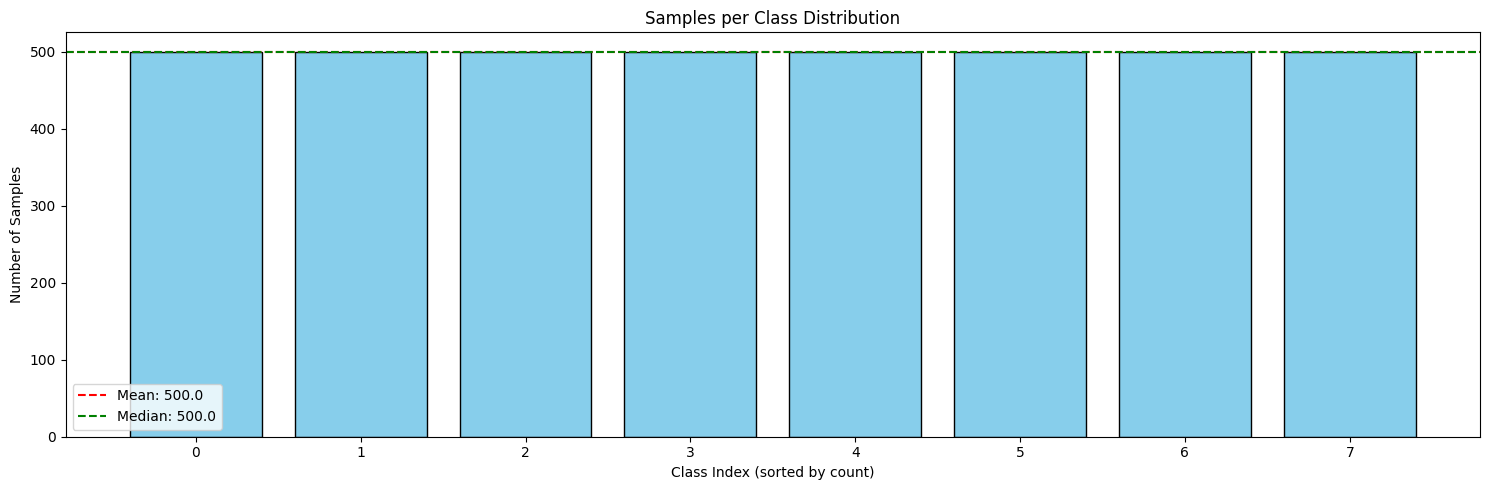


✅ Distribution plot saved as: class_distribution.png
✅ Detailed balance report saved as: class_balance_report.csv


In [8]:
################################################################################
# Block 6A - Check Class Balance (FAST - no processing needed)
################################################################################
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Load existing embeddings and labels
X = np.load(EMB_FILE)
y = np.load(LBL_FILE, allow_pickle=True)

# Count samples per class
class_counts = Counter(y)
class_counts_sorted = sorted(class_counts.items(), key=lambda x: x[1])

# Statistics
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
mean_samples = np.mean(list(class_counts.values()))
median_samples = np.median(list(class_counts.values()))

print("="*80)
print("📊 CLASS BALANCE ANALYSIS")
print("="*80)
print(f"Total classes: {len(class_counts)}")
print(f"Total samples: {len(y)}")
print(f"Min samples per class: {min_samples}")
print(f"Max samples per class: {max_samples}")
print(f"Mean samples per class: {mean_samples:.1f}")
print(f"Median samples per class: {median_samples:.1f}")
print(f"Imbalance ratio: {max_samples/min_samples:.2f}x")

# Define balance threshold
BALANCE_THRESHOLD = 1.5  # If max/min > 1.5x, consider imbalanced
IS_BALANCED = (max_samples / min_samples) <= BALANCE_THRESHOLD

if IS_BALANCED:
    print(f"\n✅ Dataset is BALANCED (ratio {max_samples/min_samples:.2f}x ≤ {BALANCE_THRESHOLD}x)")
    print("   No augmentation needed!")
else:
    print(f"\n⚠️ Dataset is IMBALANCED (ratio {max_samples/min_samples:.2f}x > {BALANCE_THRESHOLD}x)")
    print("   Augmentation recommended! Run Block 6B below.")

# Show classes with fewest samples
print("\n" + "="*80)
print("📉 CLASSES WITH FEWEST SAMPLES (Bottom 10)")
print("="*80)
for class_name, count in class_counts_sorted[:10]:
    print(f"  {class_name}: {count} samples")

# Show classes with most samples
print("\n" + "="*80)
print("📈 CLASSES WITH MOST SAMPLES (Top 10)")
print("="*80)
for class_name, count in class_counts_sorted[-10:]:
    print(f"  {class_name}: {count} samples")

# Visualize distribution
plt.figure(figsize=(15, 5))
counts = [count for _, count in class_counts_sorted]
plt.bar(range(len(counts)), counts, color='skyblue', edgecolor='black')
plt.axhline(y=mean_samples, color='red', linestyle='--', label=f'Mean: {mean_samples:.1f}')
plt.axhline(y=median_samples, color='green', linestyle='--', label=f'Median: {median_samples:.1f}')
plt.xlabel('Class Index (sorted by count)')
plt.ylabel('Number of Samples')
plt.title('Samples per Class Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Distribution plot saved as: class_distribution.png")
print("="*80)

# Save balance report
balance_report = []
for class_name, count in sorted(class_counts.items()):
    balance_report.append({
        'class': class_name,
        'samples': count,
        'percentage': f"{count/len(y)*100:.2f}%",
        'status': '✓ Good' if count >= mean_samples*0.7 else '⚠ Low'
    })

balance_df = pd.DataFrame(balance_report)
balance_df.to_csv('class_balance_report.csv', index=False)
print(f"✅ Detailed balance report saved as: class_balance_report.csv")



In [9]:
################################################################################
# Block 6B - Smart Augmentation (Embedding-Level) (cache-aware incremental augment)
################################################################################
print("\n\n" + "="*80)
print("🔄 SMART AUGMENTATION (Embedding-Level)")
print("="*80)

# ---- imports ----
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import sys, os

# ---- Helpers: locate CACHE_DIR (try existing variable else default) ----
try:
    CACHE_DIR
except NameError:
    CACHE_DIR = Path('embeddings_cache')
CACHE_DIR = Path(CACHE_DIR)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# candidate paths (try to preserve earlier names if present in workspace)
emb_cache = CACHE_DIR / 'X_emb_augmented.npy'
lbl_cache = CACHE_DIR / 'y_lbl_augmented.npy'
paths_cache = CACHE_DIR / 'paths_augmented.npy'
augmentation_report_csv = Path('augmentation_report.csv')

# Try loading embeddings/labels/paths either from workspace variables or files
def _load_var_or_file(varnames, candidates, label):
    g = globals()
    for n in varnames:
        if n in g and g[n] is not None:
            return g[n], f"variable '{n}'"
    for c in candidates:
        if c is None:
            continue
        p = Path(c)
        if p.exists():
            val = np.load(p, allow_pickle=True)
            return val, f"file: {p}"
    raise NameError(f"{label} not found (tried vars {varnames} and files {candidates})")

# Attempt to find X, y, paths in globals or in common files
emb_candidates = [emb_cache, 'X_emb.npy', 'X.npy', 'embeddings.npy']
lbl_candidates = [lbl_cache, 'y_lbl.npy', 'y.npy', 'labels.npy']
paths_candidates = [paths_cache, 'paths.npy']

try:
    X, X_source = _load_var_or_file(['X', 'X_emb', 'embeddings', 'embs'], emb_candidates, "embeddings (X)")
    print(f"✅ Loaded embeddings X from {X_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure embeddings exist in memory as X or as a file.") from None

try:
    y, y_source = _load_var_or_file(['y', 'y_lbl', 'labels', 'y_labels'], lbl_candidates, "labels (y)")
    print(f"✅ Loaded labels y from {y_source}")
except Exception as e:
    raise RuntimeError(str(e) + "\nMake sure labels exist in memory as y or as a file.") from None

try:
    paths, paths_source = _load_var_or_file(['paths', 'img_paths', 'paths_arr'], paths_candidates, "paths")
    print(f"✅ Loaded 'paths' from {paths_source}")
except Exception:
    # fallback: create dummy paths (so code runs)
    n_items = len(y) if 'y' in globals() else len(X)
    paths = np.array([f"idx_{i}" for i in range(n_items)], dtype=object)
    print("⚠️ 'paths' not found — created placeholder path names.")

# ---- compute current class stats (base dataset) ----
unique_classes, counts = np.unique(y, return_counts=True)
min_samples = int(counts.min())
max_samples = int(counts.max())
imb_ratio = max_samples / min_samples
IS_BALANCED = imb_ratio <= 1.5

if not IS_BALANCED:
    print("⚠️ Your dataset is imbalanced. Proceeding with augmentation...")
    PROCEED_WITH_AUGMENTATION = True
else:
    print("✅ Dataset is balanced. Skipping augmentation.")
    PROCEED_WITH_AUGMENTATION = False

if PROCEED_WITH_AUGMENTATION:
    # ---- configuration / performance ----
    TARGET_SAMPLES = max_samples              # dynamic: balance to current max class size
    MIN_SAMPLES_FOR_AUGMENT = 150             # informational only
    AUG_BATCH = 128                           # batch size for synthetic generation
    NOISE_STD = 0.01                          # gaussian noise stddev added to synthetic
    print(f"🎯 Target: {TARGET_SAMPLES} samples per class  (dynamic)")
    print(f"📊 Current range: {min_samples} - {max_samples} samples")
    print(f"🔧 Will augment classes with < {TARGET_SAMPLES} samples (actual target)")

    # If augmented cache exists, load it. We will check its balance and possibly incrementally augment.
    if emb_cache.exists() and lbl_cache.exists() and paths_cache.exists():
        print("⏱️ Augmented cache detected — loading augmented artifacts from cache.")
        X_augmented = np.load(emb_cache, allow_pickle=True)
        y_augmented = np.load(lbl_cache, allow_pickle=True)
        paths_augmented = np.load(paths_cache, allow_pickle=True)

        # Compute balance on cached augmented data
        cached_counts = Counter(y_augmented)
        cached_min = min(cached_counts.values())
        cached_max = max(cached_counts.values())
        print(f"\nCached augmented data range: {cached_min} - {cached_max} samples (imbalance {cached_max/cached_min:.2f}x)")

        # If cache is already fully balanced to TARGET_SAMPLES, skip. Otherwise do incremental augmentation.
        if cached_min >= TARGET_SAMPLES and cached_max <= TARGET_SAMPLES:
            print("✅ Cached augmented dataset already meets TARGET_SAMPLES for all classes. No further augmentation required.")
        else:
            # We'll only generate the missing samples per class to reach TARGET_SAMPLES
            print("🔁 Cached dataset still imbalanced vs TARGET_SAMPLES — performing incremental augmentation for missing classes...")
            incremental_stats = []

            # Build a dictionary mapping class -> current count in cached set
            class_to_count = {c: cached_counts.get(c, 0) for c in unique_classes}

            # For speed, convert X_augmented to list for append, same for labels/paths
            X_list = list(X_augmented)
            y_list = list(y_augmented)
            paths_list = list(paths_augmented)

            for class_name in tqdm(unique_classes, desc='Processing classes for incremental augmentation'):
                current = class_to_count.get(class_name, 0)
                if current >= TARGET_SAMPLES:
                    continue  # already enough
                needed = TARGET_SAMPLES - current
                synthetic_count = 0

                # Get originals for this class from the original X,y (not from cache) — better variation
                mask_orig = (y == class_name)
                orig_embs = X[mask_orig]
                if len(orig_embs) == 0:
                    # if original dataset had 0, fallback to using class embeddings from cached set
                    mask_cache = (y_augmented == class_name)
                    orig_embs = X_augmented[mask_cache]
                    if len(orig_embs) == 0:
                        print(f"⚠️ No originals found for class '{class_name}' in either original or cached data. Skipping.")
                        continue

                emb_indices = np.arange(len(orig_embs))
                synth_idx = 0

                while synthetic_count < needed:
                    batch = int(min(AUG_BATCH, needed - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"incremental_synth_{class_name}_{synth_idx}")
                        synth_idx += 1

                    synthetic_count += batch

                incremental_stats.append({
                    'class': class_name,
                    'original_in_cache': current,
                    'added': synthetic_count,
                    'new_total': current + synthetic_count
                })
                # update cached count for this class so subsequent checks use updated value
                class_to_count[class_name] = current + synthetic_count

            # Convert lists back to arrays
            X_augmented = np.array(X_list, dtype='float32')
            y_augmented = np.array(y_list, dtype=object)
            paths_augmented = np.array(paths_list, dtype=object)

            # Update augmentation report: combine previous report (if exists) with incremental report
            if augmentation_report_csv.exists():
                try:
                    prev_df = pd.read_csv(augmentation_report_csv)
                except Exception:
                    prev_df = pd.DataFrame()
            else:
                prev_df = pd.DataFrame()

            if incremental_stats:
                inc_df = pd.DataFrame(incremental_stats)
                # If prev_df has same classes, add added counts to previous synthetic; otherwise concat
                if not prev_df.empty:
                    prev_df = prev_df.set_index('class')
                    inc_df = inc_df.set_index('class')
                    for cls in inc_df.index:
                        if cls in prev_df.index:
                            prev_row = prev_df.loc[cls].to_dict()
                            # update synthetic & total
                            prev_df.at[cls, 'synthetic'] = int(prev_df.at[cls, 'synthetic']) + int(inc_df.at[cls, 'added'])
                            prev_df.at[cls, 'total'] = int(prev_df.at[cls, 'total']) + int(inc_df.at[cls, 'added'])
                        else:
                            prev_df = pd.concat([prev_df, pd.DataFrame({
                                'original': [inc_df.at[cls, 'original_in_cache']],
                                'synthetic': [inc_df.at[cls, 'added']],
                                'total': [inc_df.at[cls, 'new_total']]
                            }, index=[cls])])
                    prev_df = prev_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = prev_df
                else:
                    inc_df = inc_df.reset_index().rename(columns={'index': 'class'})
                    final_report_df = inc_df
                final_report_df.to_csv(augmentation_report_csv, index=False)
                print("\n✅ Incremental augmentation completed and augmentation_report.csv updated.")
                try:
                    print(final_report_df.to_string(index=False))
                except Exception:
                    pass
            else:
                print("ℹ️ No incremental augmentation was needed (cache already met TARGET_SAMPLES).")

            # Save updated caches
            np.save(emb_cache, X_augmented)
            np.save(lbl_cache, y_augmented)
            np.save(paths_cache, paths_augmented)
            print("\n✅ Cache files updated with incremental augmentations.")

    else:
        # No cache exists: perform full augmentation up to TARGET_SAMPLES (same approach as incremental)
        print("🔄 No augmented cache found — generating full augmented dataset up to TARGET_SAMPLES...")
        X_list = []
        y_list = []
        paths_list = []
        augmentation_stats = []

        for class_name in tqdm(unique_classes, desc='Processing classes'):
            mask_orig = (y == class_name)
            orig_embs = X[mask_orig]
            orig_paths = np.array(paths)[mask_orig]
            current_count = len(orig_embs)

            # add originals
            X_list.extend(orig_embs)
            y_list.extend([class_name] * current_count)
            paths_list.extend(orig_paths.tolist())

            if current_count < TARGET_SAMPLES:
                needed_total = TARGET_SAMPLES - current_count
                synthetic_count = 0
                emb_indices = np.arange(len(orig_embs))
                syn_idx = 0

                if len(emb_indices) == 0:
                    print(f"⚠️ Class '{class_name}' has 0 originals — skipping.")
                    continue

                while synthetic_count < needed_total:
                    batch = int(min(AUG_BATCH, needed_total - synthetic_count))

                    if len(emb_indices) == 1:
                        idx1 = idx2 = np.zeros(batch, dtype=int)
                    else:
                        idx1 = np.random.choice(emb_indices, size=batch, replace=True)
                        idx2 = np.random.choice(emb_indices, size=batch, replace=True)

                    emb1 = orig_embs[idx1]
                    emb2 = orig_embs[idx2]

                    alphas = np.random.uniform(0.3, 0.7, size=(batch, 1))
                    synthetics = alphas * emb1 + (1 - alphas) * emb2
                    noise = np.random.normal(0.0, NOISE_STD, size=synthetics.shape)
                    synthetics = synthetics + noise

                    norms = np.linalg.norm(synthetics, axis=1, keepdims=True)
                    norms[norms == 0] = 1.0
                    synthetics = synthetics / norms

                    for i in range(batch):
                        X_list.append(synthetics[i].astype('float32'))
                        y_list.append(class_name)
                        paths_list.append(f"synthetic_{class_name}_{syn_idx}")
                        syn_idx += 1

                    synthetic_count += batch

                augmentation_stats.append({
                    'class': class_name,
                    'original': current_count,
                    'synthetic': synthetic_count,
                    'total': current_count + synthetic_count
                })

        # convert and save
        X_augmented = np.array(X_list, dtype='float32')
        y_augmented = np.array(y_list, dtype=object)
        paths_augmented = np.array(paths_list, dtype=object)

        np.save(emb_cache, X_augmented)
        np.save(lbl_cache, y_augmented)
        np.save(paths_cache, paths_augmented)

        if augmentation_stats:
            aug_df = pd.DataFrame(augmentation_stats)
            aug_df.to_csv(augmentation_report_csv, index=False)
            print("\n✅ Augmentation complete and report saved.")
            print(aug_df.to_string(index=False))
        else:
            print("\nℹ️ No augmentation stats recorded (unexpected if dataset was imbalanced).")

    # ---- report final balance status ----
    new_counts = Counter(np.load(lbl_cache, allow_pickle=True))
    new_min = min(new_counts.values())
    new_max = max(new_counts.values())

    print("\n" + "="*80)
    print("📊 NEW BALANCE STATUS")
    print("="*80)
    print(f"Min samples per class: {new_min}")
    print(f"Max samples per class: {new_max}")
    print(f"New imbalance ratio: {new_max/new_min:.2f}x")

    if new_max / new_min <= 1.5:
        print("✅ Dataset is now BALANCED!")
    else:
        print("⚠️ Still some imbalance (consider increasing TARGET_SAMPLES or re-running augmentation)")

    print("\n" + "="*80)
    print("📁 AUGMENTED FILES SAVED:")
    print("="*80)
    print(f"✅ {emb_cache}")
    print(f"✅ {lbl_cache}")
    print(f"✅ {paths_cache}")

    print("\n" + "="*80)
    print("⚠️ IMPORTANT: Update Block 7 (training) to use augmented files:")
    print("="*80)
    print("Change these lines in Block 7:")
    print("  FROM:")
    print("    EMB_SRC = EMB_FILE")
    print("    LBL_SRC = LBL_FILE")
    print("  TO:")
    print("    EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy'")
    print("    LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy'")
    print("="*80)

else:
    print("\n✅ No augmentation performed. Dataset is already balanced!")
    print("   You can proceed directly to Block 7 (training).")




🔄 SMART AUGMENTATION (Embedding-Level)
✅ Loaded embeddings X from variable 'X'
✅ Loaded labels y from variable 'y'
⚠️ 'paths' not found — created placeholder path names.
✅ Dataset is balanced. Skipping augmentation.

✅ No augmentation performed. Dataset is already balanced!
   You can proceed directly to Block 7 (training).


In [10]:
"""
=========================================================
Block 7 – Enhanced SVM Training with Hyperparameter Search
=========================================================
"""

import numpy as np
import time
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Use augmented data if available
EMB_SRC = CACHE_DIR / 'X_emb_augmented.npy' if (CACHE_DIR / 'X_emb_augmented.npy').exists() else EMB_FILE
LBL_SRC = CACHE_DIR / 'y_lbl_augmented.npy' if (CACHE_DIR / 'y_lbl_augmented.npy').exists() else LBL_FILE

print("Using embeddings from:", EMB_SRC)

# ---------- Load embeddings ----------
X = np.load(EMB_SRC)
y = np.load(LBL_SRC, allow_pickle=True)
print("Loaded embeddings:", X.shape)
print("Class distribution:", {cls: np.sum(y == cls) for cls in np.unique(y)})

# ---------- Encode labels ----------
le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# ---------- Normalization ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- Train / Test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_enc,
    stratify=y_enc,
    test_size=0.15,
    random_state=42
)

print("Train/test:", X_train.shape, X_test.shape)

# =========================================================
# 🔥 HYPERPARAMETER SEARCH (Optional - comment out if slow)
# =========================================================
print("\n=== Hyperparameter Search ===")

param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
grid_search.fit(X_train, y_train)
print(f"Grid search completed in {time.time() - t0:.1f}s")
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_clf = grid_search.best_estimator_

# =========================================================
# Evaluate on test set
# =========================================================
y_pred = best_clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# =========================================================
# 🎯 ENSEMBLE: SVM + Random Forest (for even better accuracy)
# =========================================================
print("\n=== Training Ensemble (SVM + RF) ===")

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
rf_acc = rf.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Ensemble prediction (average probabilities)
svm_proba = best_clf.predict_proba(X_test)
rf_proba = rf.predict_proba(X_test)
ensemble_proba = (svm_proba + rf_proba) / 2
ensemble_pred = np.argmax(ensemble_proba, axis=1)
ensemble_acc = accuracy_score(y_test, ensemble_pred)

print(f"🏆 Ensemble Accuracy: {ensemble_acc:.4f}")

# Use best performer
if ensemble_acc > test_acc:
    print("\n✅ Using Ensemble model")
    final_clf = {
        'type': 'ensemble',
        'svm': best_clf,
        'rf': rf,
        'le': le,
        'scaler': scaler,
        'X_test': X_test,
        'y_test': y_test
    }
else:
    print("\n✅ Using SVM model")
    final_clf = {
        'type': 'svm',
        'clf': best_clf,
        'le': le,
        'scaler': scaler,
        'X_test': X_test,
        'y_test': y_test
    }

# ---------- Save artifacts ----------
with open(CLF_FILE, 'wb') as f:
    pickle.dump(final_clf, f)

print(f"\n💾 Saved classifier to: {CLF_FILE}")
print(f"📊 Final accuracy: {max(test_acc, ensemble_acc):.4f}")

Using embeddings from: embeddings_cache\X_emb.npy
Loaded embeddings: (4000, 512)
Class distribution: {'Anthracnose': np.int64(500), 'Bacterial Canker': np.int64(500), 'Cutting Weevil': np.int64(500), 'Die Back': np.int64(500), 'Gall Midge': np.int64(500), 'Healthy': np.int64(500), 'Powdery Mildew': np.int64(500), 'Sooty Mould': np.int64(500)}
Train/test: (3400, 512) (600, 512)

=== Hyperparameter Search ===
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Grid search completed in 147.6s
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.9994

✅ Test Accuracy: 1.0000

Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        75
Bacterial Canker       1.00      1.00      1.00        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       1.00      1.00      1.00        75
         Healthy    

✅ Loaded model type: svm
📊 Using SVM predictions

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        75
Bacterial Canker       1.00      1.00      1.00        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       1.00      1.00      1.00        75
         Healthy       1.00      1.00      1.00        75
  Powdery Mildew       1.00      1.00      1.00        75
     Sooty Mould       1.00      1.00      1.00        75

        accuracy                           1.00       600
       macro avg       1.00      1.00      1.00       600
    weighted avg       1.00      1.00      1.00       600



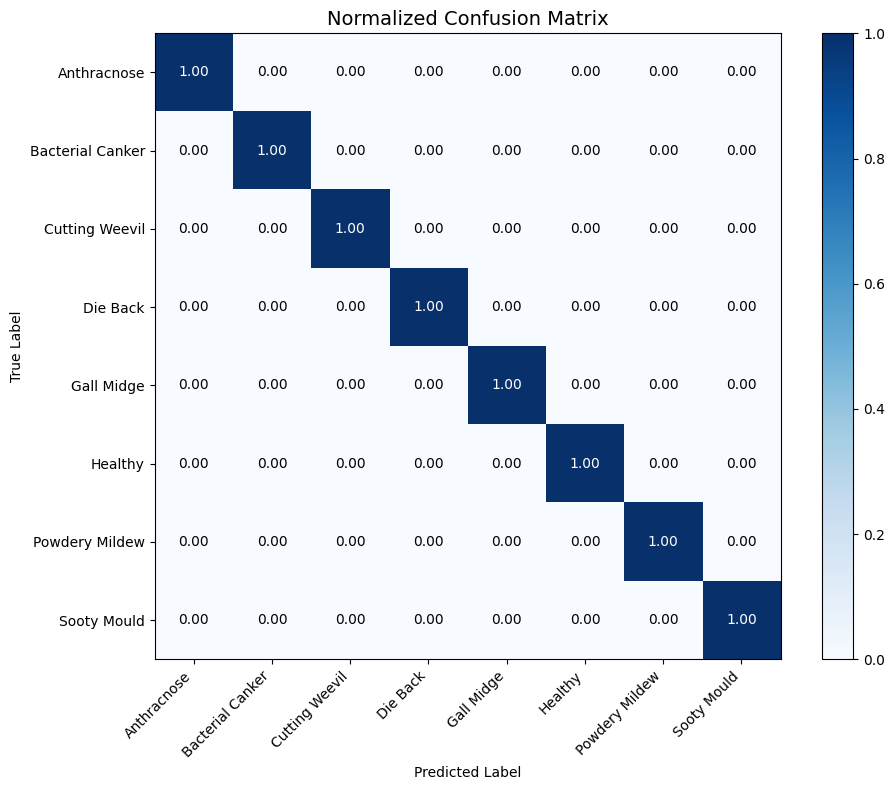


✅ Confusion matrix saved: confusion_matrix.png

5-FOLD CROSS-VALIDATION
  Fold 1: 0.9988
  Fold 2: 0.9988
  Fold 3: 1.0000
  Fold 4: 1.0000
  Fold 5: 1.0000

📈 Mean Accuracy: 0.9995 (±0.0006)

CENTROID BASELINE
💾 Saved centroids: embeddings_cache\centroids.npy
💾 Saved classes: embeddings_cache\classes.npy
📊 Centroid Accuracy: 0.9617

OPEN-SET THRESHOLD (Cosine Similarity)
🎯 Suggested threshold (TPR~0.95): 0.2579
   Use this for unknown/novel disease detection

✅ EVALUATION COMPLETE


In [11]:
"""
=========================================================
Block 8 – FIXED Evaluation (Supports SVM + Ensemble)
=========================================================
"""

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import normalize

# -------- Load classifier --------
obj = pickle.load(open(CLF_FILE, 'rb'))
model_type = obj.get('type', 'svm')
le = obj["le"]
scaler = obj["scaler"]
X_test = obj['X_test']
y_test = obj['y_test']

print(f"✅ Loaded model type: {model_type}")

# -------- Get predictions based on model type --------
if model_type == 'ensemble':
    svm_clf = obj['svm']
    rf_clf = obj['rf']
    
    # Ensemble prediction
    svm_proba = svm_clf.predict_proba(X_test)
    rf_proba = rf_clf.predict_proba(X_test)
    probs = (svm_proba + rf_proba) / 2
    y_pred = np.argmax(probs, axis=1)
    
    print("📊 Using Ensemble (SVM + RF) predictions")
else:
    clf = obj['clf']
    y_pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    
    print("📊 Using SVM predictions")

# -------- Classification Report --------
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# -------- Confusion Matrix --------
cm = confusion_matrix(y_test, y_pred).astype(float)
cmn = cm / cm.sum(axis=1)[:, None]

plt.figure(figsize=(10, 8))
plt.imshow(cmn, cmap='Blues')
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.colorbar()

# Add labels
classes = le.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cmn.max() / 2
for i, j in np.ndindex(cmn.shape):
    plt.text(j, i, f'{cmn[i, j]:.2f}',
             ha="center", va="center",
             color="white" if cmn[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved: confusion_matrix.png")

# -------- 5-Fold Cross-Validation --------
print("\n" + "="*80)
print("5-FOLD CROSS-VALIDATION")
print("="*80)

X_all = np.load(EMB_FILE)
y_all = np.load(LBL_FILE, allow_pickle=True)
y_all_enc = le.transform(y_all)
X_all_scaled = scaler.transform(X_all)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for fold, (tr, te) in enumerate(skf.split(X_all_scaled, y_all_enc), 1):
    if model_type == 'ensemble':
        svm_clf.fit(X_all_scaled[tr], y_all_enc[tr])
        rf_clf.fit(X_all_scaled[tr], y_all_enc[tr])
        
        svm_proba = svm_clf.predict_proba(X_all_scaled[te])
        rf_proba = rf_clf.predict_proba(X_all_scaled[te])
        ensemble_proba = (svm_proba + rf_proba) / 2
        fold_pred = np.argmax(ensemble_proba, axis=1)
        fold_acc = accuracy_score(y_all_enc[te], fold_pred)
    else:
        clf.fit(X_all_scaled[tr], y_all_enc[tr])
        fold_acc = clf.score(X_all_scaled[te], y_all_enc[te])
    
    accs.append(fold_acc)
    print(f"  Fold {fold}: {fold_acc:.4f}")

print(f"\n📈 Mean Accuracy: {np.mean(accs):.4f} (±{np.std(accs):.4f})")

# -------- Centroid Baseline --------
print("\n" + "="*80)
print("CENTROID BASELINE")
print("="*80)

Xn_norm = normalize(X_all, axis=1)
centroids = {c: Xn_norm[y_all_enc==c].mean(axis=0) for c in np.unique(y_all_enc)}

# Save centroids
centroid_matrix = np.vstack([centroids[c] for c in sorted(centroids.keys())])
classes_order = np.array([le.classes_[c] for c in sorted(centroids.keys())])
np.save(CENTROIDS_FILE, centroid_matrix)
np.save(CLASSES_FILE, classes_order)

print(f"💾 Saved centroids: {CENTROIDS_FILE}")
print(f"💾 Saved classes: {CLASSES_FILE}")

# Evaluate centroid on test split
_, X_test_c, _, y_test_c = train_test_split(
    Xn_norm, y_all_enc, stratify=y_all_enc, 
    test_size=0.15, random_state=42
)

def predict_centroid(emb):
    emb = emb / np.linalg.norm(emb)
    sims = centroid_matrix.dot(emb)
    return sims.argmax(), sims.max()

y_cent = [predict_centroid(e)[0] for e in X_test_c]
cent_acc = accuracy_score(y_test_c, y_cent)
print(f"📊 Centroid Accuracy: {cent_acc:.4f}")

# -------- Open-Set Threshold --------
print("\n" + "="*80)
print("OPEN-SET THRESHOLD (Cosine Similarity)")
print("="*80)

tr, val = next(skf.split(Xn_norm, y_all_enc))
centroids_tr = {c: Xn_norm[tr][y_all_enc[tr]==c].mean(axis=0) 
                for c in np.unique(y_all_enc)}

genuine_scores = []
impostor_scores = []

for i, emb in enumerate(Xn_norm[val]):
    label = y_all_enc[val][i]
    emb_norm = emb / np.linalg.norm(emb)
    sims = [emb_norm.dot(centroids_tr[c]) for c in centroids_tr]
    
    genuine_scores.append(emb_norm.dot(centroids_tr[label]))
    impostor_scores.append(max([s for c, s in zip(centroids_tr.keys(), sims) if c != label]))

genuine_scores = np.array(genuine_scores)
impostor_scores = np.array(impostor_scores)

labels_scores = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
scores = np.concatenate([genuine_scores, impostor_scores])
fpr, tpr, thresholds = roc_curve(labels_scores, scores)

idx = (np.abs(tpr - 0.95)).argmin()
suggested_thresh = thresholds[idx]
print(f"🎯 Suggested threshold (TPR~0.95): {suggested_thresh:.4f}")
print(f"   Use this for unknown/novel disease detection")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE")
print("="*80)

In [12]:
"""
=========================================================
BLOCK 9.1 – Updated Inference Helpers
Supports both SVM and Ensemble models
=========================================================
"""

import numpy as np
import pickle
from PIL import Image
import tensorflow as tf

# -------- Paths --------
CLF_FILE = "./embeddings_cache/svc_model.pkl"
CENTROIDS_FILE = "./embeddings_cache/centroids.npy"
CLASSES_FILE = "./embeddings_cache/classes.npy"
IMAGE_SIZE = (224, 224)

# -------- Load classifier --------
obj = pickle.load(open(CLF_FILE, "rb"))
model_type = obj.get('type', 'svm')
le = obj["le"]
scaler = obj["scaler"]

if model_type == 'ensemble':
    svm_clf = obj['svm']
    rf_clf = obj['rf']
    print("✅ Loaded Ensemble model (SVM + RF)")
else:
    clf = obj["clf"]
    print("✅ Loaded SVM model")

# Centroid model
centroid_matrix = np.load(CENTROIDS_FILE)
classes_order = np.load(CLASSES_FILE, allow_pickle=True)

# -------- Preprocessing --------
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE)
    img = np.array(img, dtype=np.float32)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img[None, ...]

# -------- Feature extraction --------
def extract_features(image_path):
    """Extract features using embedding_model from Block 2"""
    x = preprocess_image(image_path)
    feat = embedding_model(x, training=False).numpy().reshape(-1)
    return feat

# -------- Prediction functions --------
def predict_with_classifier(image_path, top_k=3):
    """Predict using SVM or Ensemble"""
    emb = extract_features(image_path).reshape(1, -1)
    emb = scaler.transform(emb)
    
    if model_type == 'ensemble':
        # Ensemble: average SVM and RF probabilities
        svm_proba = svm_clf.predict_proba(emb)[0]
        rf_proba = rf_clf.predict_proba(emb)[0]
        probs = (svm_proba + rf_proba) / 2
    else:
        probs = clf.predict_proba(emb)[0]
    
    idx = probs.argsort()[::-1][:top_k]
    return [(le.classes_[i], float(probs[i])) for i in idx]

def predict_with_centroid(image_path, top_k=3, return_similarity=True):
    """Predict using centroid method"""
    emb = extract_features(image_path)
    emb = emb / np.linalg.norm(emb)
    
    sims = centroid_matrix.dot(emb)
    idx = sims.argsort()[::-1][:top_k]
    
    results = [(classes_order[i], float(sims[i])) for i in idx]
    
    if return_similarity:
        return results, float(sims.max())
    return results

def predict_hybrid(image_path, top_k=3, threshold=0.75):
    """
    Hybrid prediction:
    - Use centroid for initial check
    - Fall back to classifier for low-confidence cases
    """
    results, max_sim = predict_with_centroid(image_path, top_k, return_similarity=True)
    
    if max_sim < threshold:
        # Low confidence, use classifier
        results = predict_with_classifier(image_path, top_k)
        method = "classifier"
    else:
        method = "centroid"
    
    return results, method

print("✅ Inference helpers ready")
print(f"   Model type: {model_type}")
print(f"   Classes: {len(le.classes_)}")

✅ Loaded SVM model
✅ Inference helpers ready
   Model type: svm
   Classes: 8


In [13]:
# =========================================================
# Block 9.2 — centroid baseline evaluation
# =========================================================

import numpy as np
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.metrics import accuracy_score

# Load embeddings
X = np.load('./embeddings_cache/X_emb.npy', allow_pickle=True)
y = np.load('./embeddings_cache/y_lbl.npy', allow_pickle=True)

le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# Normalize embeddings
Xn = normalize(X, axis=1)

# Compute centroids
centroids = {
    c: Xn[y_enc == c].mean(axis=0)
    for c in np.unique(y_enc)
}

def predict_centroid(emb):
    emb = emb / np.linalg.norm(emb)
    sims = [(c, emb.dot(centroids[c])) for c in centroids]
    return max(sims, key=lambda x: x[1])[0]

# Evaluate (requires X_test, y_test from earlier split)
try:
    y_pred = [predict_centroid(e) for e in X_test]
    print("Centroid accuracy on test:",
          accuracy_score(y_test, y_pred))
except NameError:
    print("⚠️ Run train/test split block first")


Centroid accuracy on test: 0.9733333333333334


In [14]:
"""
=========================================================
BLOCK 10 – FIXED Batch Prediction (Supports Ensemble)
=========================================================
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

# ---------- EDIT THIS ----------
PREDICT_DIR = "data"
# ------------------------------

OUTPUT_CSV = "predictions_results.csv"
OUTPUT_SUMMARY_CSV = "predictions_summary.csv"

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
IMAGE_SIZE = (224, 224)

# -------- Load classifier --------
print("Loading classifier...")
obj = pickle.load(open(CLF_FILE, "rb"))
model_type = obj.get('type', 'svm')
le = obj["le"]
scaler = obj["scaler"]

if model_type == 'ensemble':
    svm_clf = obj['svm']
    rf_clf = obj['rf']
    print("✅ Loaded Ensemble model (SVM + RF)")
else:
    clf = obj["clf"]
    print("✅ Loaded SVM model")

# -------- Preprocessing (EfficientNetV2) --------
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize(IMAGE_SIZE)
    img = np.array(img, dtype=np.float32)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img[None, ...]

# -------- Feature extraction --------
def extract_features(image_path):
    x = preprocess_image(image_path)
    feat = embedding_model(x, training=False).numpy().reshape(-1)
    return feat

# -------- Collect images --------
PREDICT_PATH = Path(PREDICT_DIR)
image_paths = [
    p for p in PREDICT_PATH.rglob("*")
    if p.suffix.lower() in IMAGE_EXTENSIONS
]

print(f"Found {len(image_paths)} images")

results = []
failed = []

# -------- Prediction loop --------
print("\nPredicting...")
for img_path in tqdm(image_paths, desc="Processing"):
    try:
        # Extract features
        emb = extract_features(img_path).reshape(1, -1)
        emb = scaler.transform(emb)

        # Predict based on model type
        if model_type == 'ensemble':
            svm_proba = svm_clf.predict_proba(emb)[0]
            rf_proba = rf_clf.predict_proba(emb)[0]
            proba = (svm_proba + rf_proba) / 2
            pred_idx = np.argmax(proba)
        else:
            pred_idx = clf.predict(emb)[0]
            proba = clf.predict_proba(emb)[0]

        pred_label = le.inverse_transform([pred_idx])[0]
        confidence = float(proba[pred_idx])

        # Top-3 predictions
        top3_idx = proba.argsort()[::-1][:3]
        top3_labels = le.inverse_transform(top3_idx)
        top3_probs = proba[top3_idx]

        # Compare with actual (folder name)
        actual = img_path.parent.name
        correct = actual == pred_label

        results.append({
            "image_path": str(img_path),
            "filename": img_path.name,
            "actual": actual,
            "predicted": pred_label,
            "confidence": confidence,
            "correct": correct,
            "top1": top3_labels[0],
            "top1_conf": float(top3_probs[0]),
            "top2": top3_labels[1],
            "top2_conf": float(top3_probs[1]),
            "top3": top3_labels[2],
            "top3_conf": float(top3_probs[2]),
        })

    except Exception as e:
        failed.append((str(img_path), str(e)))

# -------- Save results --------
df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)

# Summary per class
summary = df.groupby("actual").agg(
    correct_count=("correct", "sum"),
    total_count=("correct", "count"),
)
summary["accuracy"] = summary["correct_count"] / summary["total_count"]
summary = summary.sort_values("accuracy", ascending=False)
summary.to_csv(OUTPUT_SUMMARY_CSV)

# -------- Display summary --------
print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(summary.to_string())

overall_acc = df["correct"].mean()
print(f"\n📊 Overall Accuracy: {overall_acc:.4f}")

print("\n" + "="*80)
print(f"✅ Saved: {OUTPUT_CSV}")
print(f"✅ Saved: {OUTPUT_SUMMARY_CSV}")
print("="*80)

if failed:
    pd.DataFrame(failed, columns=["image", "error"]).to_csv(
        "failed_predictions.csv", index=False
    )
    print(f"⚠️ {len(failed)} failed predictions logged")

Loading classifier...
✅ Loaded SVM model
Found 4000 images

Predicting...


Processing: 100%|██████████| 4000/4000 [37:56<00:00,  1.76it/s] 



PREDICTION SUMMARY
                  correct_count  total_count  accuracy
actual                                                
Anthracnose                 500          500       1.0
Bacterial Canker            500          500       1.0
Cutting Weevil              500          500       1.0
Die Back                    500          500       1.0
Gall Midge                  500          500       1.0
Healthy                     500          500       1.0
Powdery Mildew              500          500       1.0
Sooty Mould                 500          500       1.0

📊 Overall Accuracy: 1.0000

✅ Saved: predictions_results.csv
✅ Saved: predictions_summary.csv


In [15]:
# =========================================================
# FINAL BLOCK – Export Embedding Model for Raspberry Pi
# =========================================================
import tensorflow as tf
import os

try:
    # Use the embedding_model already created in Block 2
    # It's already defined as: train_model.layers[-3].output (512-dim)
    
    # Verification
    print(f"✅ Using Embedding Model from Block 2")
    print(f"📊 Input shape: {embedding_model.input_shape}")
    print(f"📊 Output shape: {embedding_model.output_shape}")

    # 2. Convert to TensorFlow Lite (Float32)
    print("🚀 Converting to TFLite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(embedding_model)
    
    # Ensure no quantization for maximum accuracy on Pi
    converter.optimizations = [] 
    converter.target_spec.supported_types = [tf.float32]
    
    tflite_model = converter.convert()

    # 3. Save the .tflite file
    tflite_filename = "efficientnetv2_b0_embedding_512.tflite"
    with open(tflite_filename, "wb") as f:
        f.write(tflite_model)

    print(f"\n{'='*80}")
    print(f"✅ SUCCESS: {tflite_filename} exported!")
    print(f"{'='*80}")
    print(f"📂 File Size: {os.path.getsize(tflite_filename) / (1024*1024):.2f} MB")
    print(f"📊 Embedding Dimension: {embedding_model.output_shape[-1]}")
    print(f"🔧 Format: TensorFlow Lite (float32)")
    print(f"🎯 Compatible with: Raspberry Pi 3/4/5 (32/64-bit)")
    print(f"{'='*80}")

except NameError:
    print("❌ Export Failed: 'embedding_model' not found in memory")
    print("💡 Please run Block 2 (EfficientNetV2-B0 Training) first")
    print("   Block 2 creates both 'train_model' and 'embedding_model'")

except Exception as e:
    print(f"❌ Export Failed: {e}")

✅ Using Embedding Model from Block 2
📊 Input shape: (None, 224, 224, 3)
📊 Output shape: (None, 512)
🚀 Converting to TFLite...
INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp4beedshi\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp4beedshi\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmp4beedshi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)
Captures:
  2461967498784: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2461967498960: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2461967538784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967544944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967546704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967543184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967545472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967543008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967581952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461967581600: TensorSpec(shape=(), dtype=tf.resource, name=N